In [1]:
def surface_mesh_from_boundary(boundary ):
    m=boundary
    bfaces=set()
    bedges=set()
    bnodes=set()
    for f in m.Elements():
        bfaces.add(f)
        nv=len(f.vertices)
        for i in range(nv):
            e=f.edges[i]
            bedges.add(e)
            n=f.vertices[i]
            bnodes.add(n) 
    return (bfaces,bedges, bnodes)
    
def surface_genus(smesh, p):
    nf=len(smesh[0])
    print("Surface face count= ", nf)  
    ne=len(smesh[1])
    nv=len(smesh[2])
    print("Surface edge count= ", ne)
    print("Surface node count= ", nv)
    nx=nv-ne+nf
    g=int(p-nx/2)
    return g
    
def random_edge(smesh):
    import random
    edges=smesh[1]
    ne=len(smesh[1])
    number = random.randint(1, ne)
    return list(edges)[number-1]  

def LoopFields(model, **kwargs):
    mesh=model.GetMesh()
    default_values = {"connected": 1}
    default_values.update(kwargs)
    connected=default_values["connected"]
    
    #smesh=self.surface_mesh( domain )
    boundary=mesh.Boundaries(model.conductor_boundary)
    smesh=surface_mesh_from_boundary(boundary)
    g=surface_genus(smesh, connected)
    print("genus= ", g)
    fes = HCurl(mesh, order=1, nograds=True, definedon=model.total_air_region, dirichlet=model.total_boundary)
    u,v = fes.TnT()
    fesPhi = H1(mesh, order=1, definedon=model.total_air_region, dirichlet=model.total_boundary)
    phi,psi= fesPhi.TnT()
        
    loops=[]
    for k in range(g):
        gfu = GridFunction(fes)
        id=random_edge(smesh)
        edge_dofs = fes.GetDofNrs(id)[0]   
            
        #edge_dofs=427
            
        gfu.vec[:] = 0
        gfu.vec[edge_dofs] = 1
        print("edge DOF = ", edge_dofs)

        fes.FreeDofs().__setitem__(edge_dofs,False)

        a = BilinearForm(fes)
        a += curl(u)*curl(v)*dx
        f=LinearForm(fes)
        with TaskManager():
            a.Assemble()
            f.Assemble()
        fr=-a.mat*gfu.vec

        gfu=solver.iccg_solve(fes, gfu, a, fr.Evaluate(), tol=1.e-16, max_iter=200, accel_factor=0)

        gfPhi = GridFunction(fesPhi)
        a = BilinearForm(fesPhi)
        a += grad(phi)*grad(psi)*dx
        f=LinearForm(fesPhi)
        f += grad(psi)*gfu*dx
        with TaskManager():
            a.Assemble()
            f.Assemble()
    
        gfPhi=solver.iccg_solve(fesPhi, gfPhi, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=1.0)  
        gfw=gfu-grad(gfPhi)

        Draw(gfw, mesh)
        
        a = BilinearForm(fes)
        a += u*v*dx
        f=LinearForm(fes)
        f += gfw*v*dx
        with TaskManager():
            a.Assemble()
            f.Assemble()
        gfw= GridFunction(fes)
        gfw=solver.iccg_solve(fes, gfw, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=1.0) 

        Draw(gfw, mesh)
        
        gft=gfw
        for kd in range(len(loops)):
            prod=Integrate(gfw*loops[kd]*dx, mesh)
            for i in range(len(gft.vec)):
                gft.vec[i] -=prod*loops[kd].vec[i]
      
        norm2=Integrate(gft*gft*dx, mesh)
        norm=sqrt(norm2)
        for i in range(len(gft.vec)):
            gft.vec[i]/=norm
              
        loops.append(gft)       
    return loops

In [2]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
#from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
from BathPlateModel import BathPlateModel
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from HtoOmega import HtoOmega
#model=Cylinder_Yaxis_1Layer(sigma=5e7)
model=BathPlateModel(holes=1,outerBox="sphere", boxx=0.2, div_thick=2)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 1    Thickness: 0.00635
boxx=  0.2  boxy=  0.28  boxz=  0.4
div_thick=  2
name: hole1   mass: 7.619999999999999e-06   center: (0.02, 3.21245e-20, 5.42769e-20)
name: to_side   mass: 1.7145000000000006e-05   center: (-0.00444444, 0.0161111, 5.0721e-20)
name: from_side   mass: 1.7145000000000006e-05   center: (-0.00444444, -0.0161111, -9.96048e-21)
name: air   mass: 0.00023213000000000004   center: (-1.82448e-18, -2.2806e-19, -2.27038e-19)
name: reduced   mass: 0.033236281638291114   center: (-1.60174e-17, -1.51188e-17, 1.54601e-19)
conductive_region: to_side|from_side
Conductor boundary: conductorBND|interface
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced': 1.2566370614359173e-06, 'hole1': 1.2566370614359173e-06, 'hole2': 1.2

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [ ]:
LoopFields(model)

Surface face count=  2842
Surface edge count=  4263
Surface node count=  1421
genus=  1
edge DOF =  2420
enter iccg_solve
Dof= 16708    matrix size= 95924.0
結果のノルム: 3.000926291961219e-12
power=  1274.3774507025043
enter iccg_solve
Dof= 2731    matrix size= 11853.0
結果のノルム: 3.6410459018385385e-16
power=  0.006929504541657092


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [ ]:
import math
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=False
feorder=1
mu=4e-7*math.pi
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

In [ ]:
#field=UNIF(0,1,0,0)
field=model.coil.field
#coil=UNIF(0,0,0.01,0)
Bv=Bfield(field)
Hv=Bv/mu
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega)     
fesTOmega=fesT*fesOmega
(T,omega),(W, psi) = fesTOmega.TnT() 
gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega =gfTOmega.components
a= BilinearForm(fesTOmega)
a +=Mu*grad(omega)*grad(psi)*dx(air_region)
a +=Mu*(T+grad(omega))*(W+grad(psi))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

In [ ]:
surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

In [ ]:
f = LinearForm(fesTOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesTOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesTOmega.FreeDofs()] = fcut

# Add Neumann condition terms
f += (normal*Bv)*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfTOmega = GridFunction(fesTOmega)   #Clear gfA
gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-10, max_iter=200, accel_factor=1.1, complex=jomega) 
gfT, gfOmega=gfTOmega.components

fesOt=H1(mesh, order=feorder, definedon=total_region, complex=jomega)
fesOr=H1(mesh, order=feorder, definedon=reduced_region, complex=jomega)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))
#Oxr.Set(Ov, BND, mesh.Boundaries(total_boundary))

Bt=(gfT+grad(Ot))*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu
Bfield=Bt+Br+Bs
Jfield=curl(gfT)

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


In [ ]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region, mesh))
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

In [ ]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

Apply Coil field, 　Dirichlet=False, feOrder=1

B field real [0, 0.02]
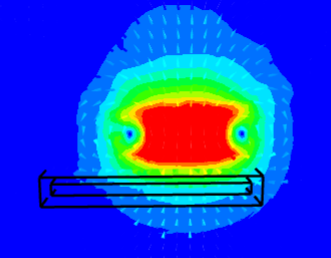

B field img [0, 0.005]
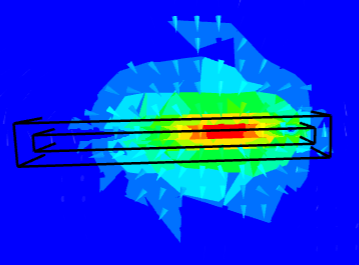

center magnetic field =  ((0.004635895363218085-0.0001268345783477668j), (-0.00017923651668769089-9.178679015096617e-05j), (0.0057654269524445275-0.003409379186076971j))

Apply Coil field, 　Dirichlet=False, feOrder=1

J field real [0, 5e5]
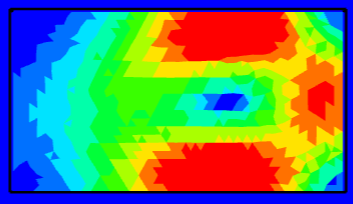

J field imag [0, 2e6]
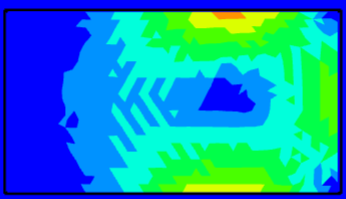

Average Joule loss=  0.33620481997953966  <-->0.3486242392846813 (A-Phi, feOrder=3)

Apply Coil field, 　Dirichlet=False, feOrder=1, ndiv=2

J field real [0, 5e5]
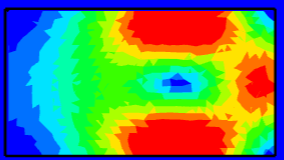

J field imag [0, 2e6]
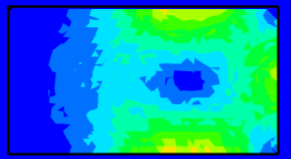

 Average Joule loss=  0.34020492830904586

Apply Coil field, 　Dirichlet=False, feOrder=1, ndiv=4

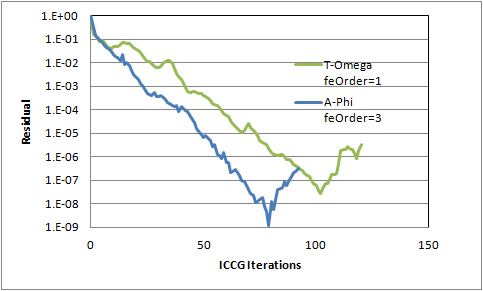

J field real [0, 5e5]
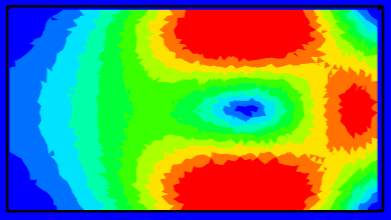

J field imag [0, 2e6]
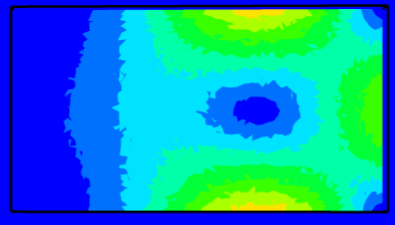

Average Joule loss=  0.34396471546108465